# Imports

In [26]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [27]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Download TKL data from YF

In [28]:
tickers_yf = {
    "y"     : f"{project_config['TKL']}",
 }

desired_order = [
    "Date",
    "y",
  ]

In [29]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

if project_config['TKL'] == 'TNYA':
  start_date = pd.to_datetime("30.07.2022", format="%d.%m.%Y")

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# Fill missing daily values for macro data (monthly)
ts_yf = ts_yf.fillna(method='ffill').fillna(method='bfill')
ts_yf = ts_yf.reset_index().rename(columns={"Date": "Date",})

print(f"\n\nDataset for y={project_config['TKL']}")
display(ts_yf.head(1))
display(ts_yf.tail(1))
ts_yf.info()


[*********************100%***********************]  1 of 1 completed



Dataset for y=NVDA


Ticker,Date,y
0,2006-10-23,0.48256


Ticker,Date,y
4820,2025-12-19,180.990005


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4821 entries, 0 to 4820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    4821 non-null   datetime64[ns]
 1   y       4821 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 75.5 KB


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random # Needed for shuffling

# Setup Directories
OUT_ROOT_DIR = f"{os.getenv('PROJECT_PATH')}{project_config['images_directory']}{project_config['TKL']}_graphs/"
INFERENCE_DIR = f"{OUT_ROOT_DIR}pred/"

# If the directory exists, delete it and all its contents
if os.path.exists(INFERENCE_DIR):
  shutil.rmtree(INFERENCE_DIR)

# Now create it fresh
os.makedirs(OUT_ROOT_DIR, exist_ok=True)
os.makedirs(INFERENCE_DIR, exist_ok=True)

# -----------------------
# Prepare data
# -----------------------
df = ts_yf.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
visual_df = df[-int(project_config['FASTAI.WINDOW_DAYS']):] # capture the last 260 days from today
infernce_df = df[-int(project_config['FASTAI.WINDOW_DAYS']):] # capture the last 260 days from today
last_date_obj = infernce_df.iloc[-1]['Date'].date()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(infernce_df['y'].values)
ax.set_axis_off()
plt.tight_layout()

inference_image_path =f"{INFERENCE_DIR}{project_config['TKL']}_{last_date_obj}_inference.png"
plt.savefig(inference_image_path, bbox_inches="tight", pad_inches=0)

plt.close()

--------- RECOMMANDATION FOR NVDA -----------

Horizon: 22 business days from 2025-12-19
BUY: 59.20%
KEEP: 40.80%
Final Decision: BUY



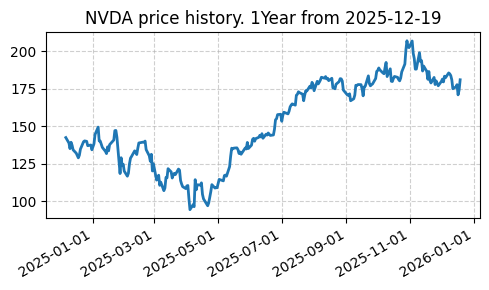

In [35]:
from fastai.vision.all import *

fastai_model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.fastai.pkl"
inference_image_path =f"{INFERENCE_DIR}{project_config['TKL']}_{last_date_obj}_inference.png"


# No need to define the DataBlock or architecture again
learn_inf = load_learner(fastai_model_path)

# Run prediction
pred_class, pred_idx, probs = learn_inf.predict(inference_image_path)

filename_from_image_path = inference_image_path.split('/')[-1]

# Split by underscore to get the date part. Parts will be ['NVDA', '2025-12-19', 'inference.png']
parts_from_image_path = filename_from_image_path.split('_')

# The date string is at index 1
end_date_str = parts_from_image_path[1]


print(f"--------- RECOMMANDATION FOR {project_config['TKL']} -----------\n")
print(f"Horizon: {project_config['FASTAI.FUTURE_DAYS']} business days from {end_date_str}")

inference_image_path =f"{INFERENCE_DIR}{project_config['TKL']}_{last_date_obj}_inference.png"
plt.savefig(inference_image_path, bbox_inches="tight", pad_inches=0)

plt.close()

# Fix: Access vocab from learn_inf.dls
probs_map = dict(zip(learn_inf.dls.vocab, map(float, probs)))
sorted_probs = sorted(probs_map.items(), key=lambda x: x[1], reverse=True)

for category, prob in sorted_probs:
  print(f"{category}: {prob*100:.2f}%")

print(f"Final Decision: {pred_class}\n")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Create the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# 2. Plot the inference data
# Note: Using visual_df['Date'] directly ensures matplotlib handles the timeline
ax.plot(visual_df['Date'], visual_df['y'], color='#1f77b4', linewidth=2, label='Price')

# 3. Formatting the X-axis (Dates)
# This prevents dates from overlapping and makes them readable
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.autofmt_xdate() # Automatically tilts the dates for better fit

# 4. Add Labels and Titles
ax.set_title(f"{project_config['TKL']} price history. 1Year from {end_date_str}")
ax.grid(True, linestyle='--', alpha=0.6)
# 5. Final touches
plt.tight_layout()
plt.show()